<a href="https://colab.research.google.com/github/lrc9859/Git-Assignment/blob/master/RNN_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes some content and inspiration from 
- [Dive into Deep Learning Book](http://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html)
- [NYU's Deep Learning Course](https://atcold.github.io/pytorch-Deep-Learning/en/week06/06-3/)
- [Neuromatch Deep Learning Tutorials](https://deeplearning.neuromatch.io/tutorials/W2D3_ModernRecurrentNeuralNetworks/student/W2D3_Tutorial2.html#section-1-2-train-and-test-the-network)

# Setup

In [ ]:
import math
import time
import random
import collections
import six

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F

from torchtext.legacy import data, datasets

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def pad_sequences(sequences, maxlen=None, dtype='int32',
                  padding='pre', truncating='pre', value=0.):
    if not hasattr(sequences, '__len__'):
        raise ValueError('`sequences` must be iterable.')
    lengths = []
    for x in sequences:
        if not hasattr(x, '__len__'):
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))
        lengths.append(len(x))

    num_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)
    if isinstance(value, six.string_types) and dtype != object and not is_dtype_str:
        raise ValueError("`dtype` {} is not compatible with `value`'s type: {}\n"
                         "You should set `dtype=object` for variable length strings."
                         .format(dtype, type(value)))

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" '
                             'not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s '
                             'is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

def to_categorical(y, num_classes=None, dtype='float32'):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical


class QRSU():
    """
    From Hochreiter&Schmidhuber(1997):

        The goal is to classify sequences. Elements and targets are represented locally
        (input vectors with only one non-zero bit). The sequence starts with an E, ends
        with a B (the "trigger symbol") and otherwise consists of randomly chosen symbols
        from the set {a, b, c, d} except for two elements at positions t1 and t2 that are
        either X or Y . The sequence length is randomly chosen between 100 and 110, t1 is
        randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60.
        There are 4 sequence classes Q, R, S, U which depend on the temporal order of X and Y.
        The rules are:
            X, X -> Q,
            X, Y -> R,
            Y , X -> S,
            Y , Y -> U.

    """

    def __init__(self, length_range=(100, 111), t1_range=(10, 21), t2_range=(50, 61),
                 batch_size=32, seed=None):

        self.classes = ['Q', 'R', 'S', 'U']
        self.n_classes = len(self.classes)

        self.relevant_symbols = ['X', 'Y']
        self.distraction_symbols = ['a', 'b', 'c', 'd']
        self.start_symbol = 'B'
        self.end_symbol = 'E'

        self.length_range = length_range
        self.t1_range = t1_range
        self.t2_range = t2_range
        self.batch_size = batch_size

        if seed is not None:
            np.random.seed(seed)

        all_symbols = self.relevant_symbols + self.distraction_symbols + \
                      [self.start_symbol] + [self.end_symbol]
        self.n_symbols = len(all_symbols)
        self.s_to_idx = {s: n for n, s in enumerate(all_symbols)}
        self.idx_to_s = {n: s for n, s in enumerate(all_symbols)}

        self.c_to_idx = {c: n for n, c in enumerate(self.classes)}
        self.idx_to_c = {n: c for n, c in enumerate(self.classes)}

    def generate_pair(self):
        length = np.random.randint(self.length_range[0], self.length_range[1])
        t1 = np.random.randint(self.t1_range[0], self.t1_range[1])
        t2 = np.random.randint(self.t2_range[0], self.t2_range[1])

        x = np.random.choice(self.distraction_symbols, length)
        x[0] = self.start_symbol
        x[-1] = self.end_symbol

        y = np.random.choice(self.classes)
        if y == 'Q':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[0]
        elif y == 'R':
            x[t1], x[t2] = self.relevant_symbols[0], self.relevant_symbols[1]
        elif y == 'S':
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[0]
        else:
            x[t1], x[t2] = self.relevant_symbols[1], self.relevant_symbols[1]

        return ''.join(x), y

    # encoding/decoding single instance version

    def encode_x(self, x):
        idx_x = [self.s_to_idx[s] for s in x]
        return to_categorical(idx_x, num_classes=self.n_symbols)

    def encode_y(self, y):
        idx_y = self.c_to_idx[y]
        return to_categorical(idx_y, num_classes=self.n_classes)

    def decode_x(self, x):
        x = x[np.sum(x, axis=1) > 0]    # remove padding
        return ''.join([self.idx_to_s[pos] for pos in np.argmax(x, axis=1)])

    def decode_y(self, y):
        return self.idx_to_c[np.argmax(y)]

    # encoding/decoding batch versions

    def encode_x_batch(self, x_batch):
        return pad_sequences([self.encode_x(x) for x in x_batch],
                             maxlen=self.length_range[1])

    def encode_y_batch(self, y_batch):
        return np.array([self.encode_y(y) for y in y_batch])

    def decode_x_batch(self, x_batch):
        return [self.decode_x(x) for x in x_batch]

    def decode_y_batch(self, y_batch):
        return [self.idx_to_c[pos] for pos in np.argmax(y_batch, axis=1)]

    def __len__(self):
        """ Let's assume 1000 sequences as the size of data. """
        return int(1000. / self.batch_size)

    def __getitem__(self, index):
        batch_x, batch_y = [], []
        for _ in range(self.batch_size):
            x, y = self.generate_pair()
            batch_x.append(x)
            batch_y.append(y)
        return self.encode_x_batch(batch_x), self.encode_y_batch(batch_y)

    class DifficultyLevel:
        """ On HARD, settings are identical to the original settings from the '97 paper."""
        EASY, NORMAL, MODERATE, HARD, NIGHTMARE = range(5)

    @staticmethod
    def get_predefined_generator(difficulty_level, batch_size=32, seed=8382):
        EASY = QRSU.DifficultyLevel.EASY
        NORMAL = QRSU.DifficultyLevel.NORMAL
        MODERATE = QRSU.DifficultyLevel.MODERATE
        HARD = QRSU.DifficultyLevel.HARD

        if difficulty_level == EASY:
            length_range = (7, 9)
            t1_range = (1, 3)
            t2_range = (4, 6)
        elif difficulty_level == NORMAL:
            length_range = (30, 41)
            t1_range = (2, 6)
            t2_range = (20, 28)
        elif difficulty_level == MODERATE:
            length_range = (60, 81)
            t1_range = (10, 21)
            t2_range = (45, 55)
        elif difficulty_level == HARD:
            length_range = (100, 111)
            t1_range = (10, 21)
            t2_range = (50, 61)
        else:
            length_range = (300, 501)
            t1_range = (10, 81)
            t2_range = (250, 291)
        return QRSU(length_range, t1_range, t2_range,
                                          batch_size, seed)

In [ ]:
def plot_train_val(x, train, val, train_label,
                   val_label, title, y_label,
                   color):

  plt.plot(x, train, label=train_label, color=color)
  plt.plot(x, val, label=val_label, color=color, linestyle='--')
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel(y_label)
  plt.title(title)


def count_parameters(model):
  parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
  return parameters


def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight)


#  Dataset Loader
def load_dataset(sentence_length=50, batch_size=32, seed=522):

  TEXT = data.Field(sequential=True,
                    tokenize=nltk.word_tokenize,
                    lower=True,
                    include_lengths=True,
                    batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  # If no specific vector embeddings are specified,
  # Torchtext initializes random vector embeddings
  # which would get updated during training through backpropagation.
  TEXT.build_vocab(train_data)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                  batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                  repeat=False, shuffle=True)
  vocab_size = len(TEXT.vocab)

  print(f"Data loading is completed. Sentence length: {sentence_length}, "
        f"Batch size: {batch_size}, and seed: {seed}")

  return TEXT, vocab_size, train_iter, valid_iter, test_iter


def text_from_dict(arr, dictionary):
  text = []
  for element in arr:
    text.append(dictionary[element])
  return text


def view_data(TEXT, train_iter):
  for idx, batch in enumerate(train_iter):
    text = batch.text[0]
    target = batch.label

    for itr in range(25, 30):
      print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
      print('Label: ', int(target[itr].item()), '\n')

    print('[0: Negative Review, 1: Positive Review]')
    if idx==0:
      break


# Intro to RNNs

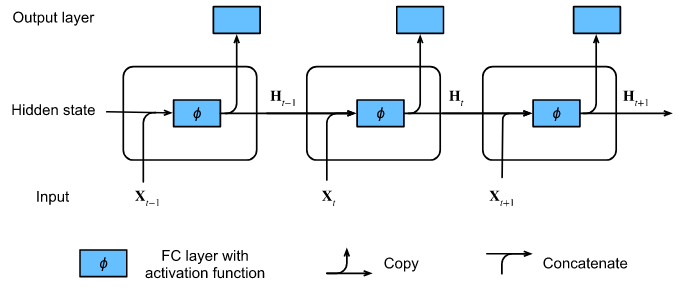

# An Example Task

Original experiment from Hochreiter & Schmidhuber (1997).

The goal is to classify sequences. Elements and targets are represented locally (input vectors with only one non-zero bit). The sequence starts with an B, ends with a E (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set {a, b, c, d} except for two elements at positions t1 and t2 that are either X or Y. For the DifficultyLevel.HARD case, the sequence length is randomly chosen between 100 and 110, t1 is randomly chosen between 10 and 20, and t2 is randomly chosen between 50 and 60. There are 4 sequence classes Q, R, S, and U, which depend on the temporal order of X and Y.

The rules are:

X, X -> Q,

X, Y -> R,

Y, X -> S,

Y, Y -> U.


In [ ]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [ ]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## Vanilla RNN Model Definition

In [ ]:
class ScratchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.c2h = nn.Linear(input_size+hidden_size, hidden_size)
        self.c2o = nn.Linear(input_size+hidden_size, output_size)

 
    def forward(self, x, hidden):
        combined = torch.cat(x, hidden)
        hidden = self.c2h(combined)
        output = self.c2o(combined)
        return output, hidden



## Training Loop Definition

In [ ]:
def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # TODO: Fill in training code 

    return num_correct, loss.item()

## Testing Loop Definition

In [ ]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            # TODO: Fill in testing code

    return num_correct, loss.item()

## RNN Evaluation

In [ ]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            sequence_end = torch.tensor([len(sequence) for sequence in data_decoded]) - 1
            output = output[torch.arange(data.shape[0]).long(), sequence_end, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [ ]:
evaluate_model(model, difficulty)

## Vanilla GRU Definition

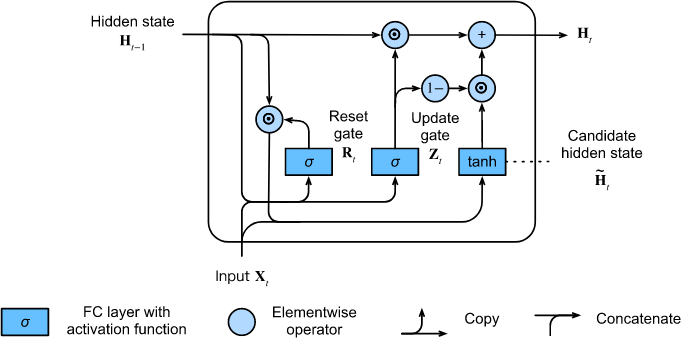

In [ ]:
class SimpleGRU(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        # TODO: Define weights

 
    def forward(self, x):
        # TODO: Define forward pass

## GRU Evaluation

In [ ]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleGRU(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [ ]:
evaluate_model(model, difficulty)

## Peeking at the computation graph

# More realistic data

In [ ]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(seed=SEED)
view_data(TEXT, train_iter)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 26.9MB/s]


LookupError: ignored

## Model Definition

- Use nn.Embedding. You are given the vocab_size which is the size of the dictionary of embeddings, and the embed_size which is the size of each embedding vector.

- Use PyTorch's [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) class for convinience

- Add 2 RNN layers. This would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. 

- Determine the size of inputs and outputs to the fully-connected layer.


In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size,
               device):
    super(VanillaRNN, self).__init__()
    self.n_layers= layers
    self.hidden_size = hidden_size
    self.device = device
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the Vanilla RNN components")
    ####################################################################
    # Define the embedding
    self.embeddings = ...
    # Define the RNN layer
    self.rnn = ...
    # Define the fully connected layer
    self.fc = ...

  def forward(self, inputs):
    input = self.embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 = torch.zeros(2, input.size()[1], self.hidden_size).to(self.device)
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2)
    h_n = h_n.contiguous().reshape(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)

    return logits

## Uncomment to test VanillaRNN class
# sampleRNN = VanillaRNN(2, 10, 50, 1000, 300, DEVICE)
# print(sampleRNN)

## Training Loop Definition

In [ ]:
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    #train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      # TODO: fill in training code
    

    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1}, '
          f'Training Loss: {running_loss/len(train_iter):.4f}, '
          f'Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        # TODO: Fill in validation code

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, '
           f'Validation Accuracy: {100*correct/total: .2f}%')

  return train_loss, train_acc, validation_loss, validation_acc

## Testing Loop Definition

In [ ]:
# Testing function
def test(model, data, device):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(data):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

## Evaluation

In [ ]:
# Model hyperparamters
learning_rate = 0.0002
layers = 2
output_size = 2
hidden_size = 50  # 100
embedding_length = 100
epochs = 10


# Initialize model, training and testing
set_seed(SEED)
vanilla_rnn_model = VanillaRNN(layers, output_size, hidden_size, vocab_size,
                               embedding_length, DEVICE)
vanilla_rnn_model.to(DEVICE)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model,
                                                                                               DEVICE,
                                                                                               train_iter,
                                                                                               valid_iter,
                                                                                               epochs,
                                                                                               learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))
test_accuracy = test(vanilla_rnn_model, DEVICE, test_iter)
print(f'Test Accuracy: {test_accuracy} with len=50\n')

# Number of model parameters
print(f'Number of parameters = {count_parameters(vanilla_rnn_model)}')


# Plot accuracy curves
plt.figure()
plt.subplot(211)
plot_train_val(np.arange(0, epochs), vanilla_train_acc, vanilla_validation_acc,
               'train accuracy', 'val accuracy',
               'Vanilla RNN on IMDB text classification', 'accuracy',
               color='C0')
plt.legend(loc='upper left')
plt.subplot(212)
plot_train_val(np.arange(0, epochs), vanilla_train_loss,
               vanilla_validation_loss,
               'train loss', 'val loss',
               'Vanilla RNN on IMDB text classification',
               'loss [a.u.]',
               color='C0')
plt.legend(loc='upper left')
plt.show()

## Comparing with longer input length

In [ ]:
TEXT_long, vocab_size_long, train_iter_long, valid_iter_long, test_iter_long = load_dataset(sentence_length=200)

In [ ]:
# Model hyperparamters
learning_rate = 0.0002
layers = 2
output_size = 2
hidden_size = 50  # 100
embedding_length = 100
epochs = 10

# Initialize model, training, testing
set_seed(SEED)
vanilla_rnn_model_long = VanillaRNN(layers, output_size, hidden_size,
                                    vocab_size_long, embedding_length, DEVICE)
vanilla_rnn_model_long.to(DEVICE)
vanilla_rnn_start_time_long = time.time()
vanilla_train_loss_long, vanilla_train_acc_long, vanilla_validation_loss_long, vanilla_validation_acc_long = train(vanilla_rnn_model_long,
                                                                                                                   DEVICE,
                                                                                                                   train_iter_long,
                                                                                                                   valid_iter_long,
                                                                                                                   epochs,
                                                                                                                   learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time_long))
test_accuracy = test(vanilla_rnn_model_long, DEVICE, test_iter_long)
print(f'Test Accuracy: {test_accuracy} with len=200\n')

# Number of parameters
print(f'\nNumber of parameters = {count_parameters(vanilla_rnn_model_long)}')

In [ ]:
# Compare accuracies of model trained on different sentence lengths
plot_train_val(np.arange(0, epochs), vanilla_train_acc,
               vanilla_validation_acc,
               'train accuracy, len=50', 'val accuracy, len=50',
               '', 'accuracy',
               color='C0')
plot_train_val(np.arange(0, epochs), vanilla_train_acc_long,
               vanilla_validation_acc_long,
               'train accuracy, len=200', 'val accuracy, len=200',
               'Training and Validation Accuracy for Sentence Lengths 50 and 200',
               'accuracy',
               color='C1')
plt.legend(loc='upper left')
plt.show()